TODOs

* check whether performance is better with amplitude or intensity as model output
* make the model robust to arbitrary scaling/incorrect normalization of the diffracted intensity
* check consistency of tf's fft implementation with others
* look at perceptual loss like FeatureLoss based on the gram matrix. https://www.reddit.com/r/deeplearning/comments/t8okw7/can_a_cnn_be_used_as_an_autoencoder_for_upscaling/
* Possibly styleGAN, neural style transfer, VGG features, VAE-GAN, fft based loss, gradient loss, or vq-vae. look up those sorts of architectures. https://www.tensorflow.org/tutorials/generative/style_transfer#define_content_and_style_representations
* probe-based support


* Use perceptual loss for reconstruction. Need to set the weights. Read Perceptual Losses for Real-Time Style Transfer
and Super-Resolution
* Reflection invariance: do augmentation to reflect this.
* consistency check on magnitude constraint
* Fully Convolutional Networks for Semantic Segmentation, explore and discuss. Make a slide explaining the idea.
* MC Dropout https://arxiv.org/pdf/1511.02680.pdf
* https://arxiv.org/pdf/1511.02680.pdf

In [1]:
import os
import tf_helper as hh
import fourier as f

import tensorflow_probability as tfp


tfk = hh.tf.keras
tfkl = hh.tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

2022-10-11 14:58:16.169255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 14:58:16.257123: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 14:58:16.610667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-11 14:58:16.610708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
path = '.'

import sys
import os
sys.path.append(path)
sys.path.append('PtychoNN/TF2/')

In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)

In [4]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Oct 11 14:58:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 63%   58C    P8    48W / 420W |  19571MiB / 24576MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

In [5]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
import matplotlib

import keras_helper

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

# importlib.reload(keras_helper)
# from keras_helper import *
from skimage.transform import resize

In [6]:
matplotlib.rcParams['font.size'] = 12

### Some training parameters

In [7]:
h,w=64,64
nepochs=20
#wt_path = 'wts4' #Where to store network weights
wt_path = 'wts4.1'
batch_size = 32

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [8]:
data_diffr = np.load(path+'/PtychoNN/data/20191008_39_diff.npz')['arr_0']
data_diffr.shape

(161, 161, 256, 256)

In [9]:
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

  0%|          | 0/161 [00:00<?, ?it/s]

In [10]:
real_space = np.load(path+'/PtychoNN/data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

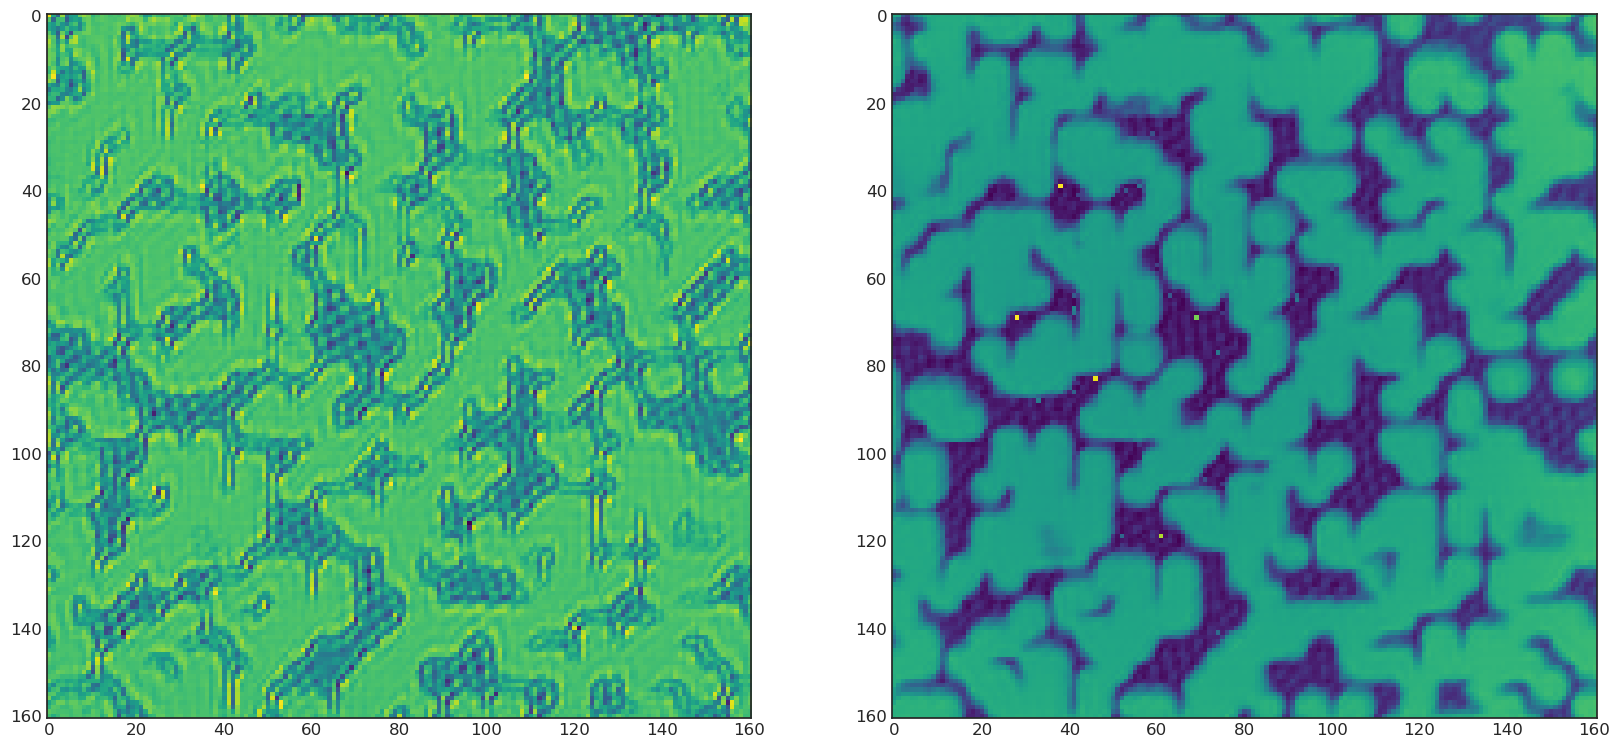

In [11]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [12]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [13]:
filt = f.lowpass_g(.6, np.ones(h), sym = True)
#filt = f.lowpass_g(.9, np.ones(h), sym = True)
# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

2022-10-11 14:58:37.232152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 14:58:37.232881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:58:37.233048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:58:37.233164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

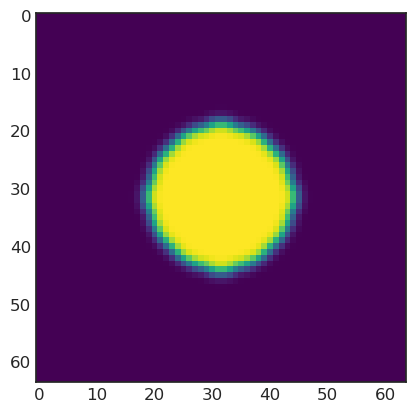

In [14]:
plt.imshow(probe)

In [15]:
N = h
assert h == w

### Load experimental dataset (currently *not* being used)

In [16]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# def blowup(img):
#     N = img.shape[0]
#     assert img.shape[1] == N
#     cropped = img[N // 4: -N // 4, N // 4: -N // 4]
#     return resize(cropped.copy(), (N, N))

def stack(a1, a2):
    return np.array((a1, a2)).reshape((-1, N, N, 1))

def augment_inversion(Y_I_train, Y_phi_train):
    phi = stack(Y_phi_train, -Y_phi_train)
#     phi_off = np.random.uniform(size = phi.size).reshape(phi.shape)
#     phi = np.mod(phi + phi_off)
    return stack(Y_I_train, Y_I_train[:, ::-1, ::-1, :]), stack(Y_phi_train, -Y_phi_train)

X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

# # resize to fill the grid better
# X_train = np.array([blowup(arr) for arr in X_train]) * probe[None, ..., None]
# X_test = np.array([blowup(arr) for arr in X_test]) * probe[None, ..., None]

tmp1, tmp2 = Y_I_train, Y_I_test

(16100, 64, 64, 1) (3600, 64, 64, 1)


In [17]:
# X_train = np.array(hh.pad_and_diffract(Y_I_train, h, w, pad=False)[1])
# X_test = np.array(hh.pad_and_diffract(Y_I_test, h, w, pad=False)[1])

In [18]:
nphotons = 1e8

def _preprocess(sample):
    # run ff diffraction
    amplitude = hh.pad_and_diffract(sample, h, w, pad=False)[1]
    # sample from Poisson observation likelihood
    observed_amp = tf.sqrt((tfd.Independent(tfd.Poisson(amplitude**2))).sample()) + 0.5
    return observed_amp

def preprocess(Y_I_train, Y_phi_train, Y_I_test, Y_phi_test):
    Y_I_train = Y_I_train *  probe[None, ..., None]
    Y_I_test = Y_I_test *  probe[None, ..., None]

    Y_I_test /= max(Y_I_train.max(), Y_I_test.max())
    Y_I_train /= (Y_I_train.max())

    # Augment using the inversion symmetry
#     Y_I_train, Y_phi_train = augment_inversion(Y_I_train, Y_phi_train)

    prenorm_train = (Y_I_train**2).sum(axis = 3).sum(axis = 2).sum(axis = 1)
    prenorm_test = (Y_I_test**2).sum(axis = 3).sum(axis = 2).sum(axis = 1)
    
    norm_train = np.sqrt(nphotons / prenorm_train)[:, None, None, None]
    norm_test = np.sqrt(nphotons / prenorm_test)[:, None, None, None]

    Y_I_train, Y_phi_train = shuffle(norm_train * Y_I_train, Y_phi_train, random_state=0)
    Y_I_test = norm_test * Y_I_test

    obj_train = hh.combine_complex(Y_I_train, Y_phi_train)
    obj_test = hh.combine_complex(Y_I_test, Y_phi_test)

    # Simulate diffraction
    X_train = (tf.data.Dataset.from_tensor_slices(obj_train)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_train = np.vstack(list(iter(X_train)))

    X_test = (tf.data.Dataset.from_tensor_slices(obj_test)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_test = np.vstack(list(iter(X_test)))
    
    empirical_norm = max(Y_I_train.max(), Y_I_test.max())
#     Y_I_train /= (Y_I_train.max())
    return X_train / empirical_norm, Y_I_train / empirical_norm, Y_phi_train,\
        X_test / empirical_norm, Y_I_test / empirical_norm, Y_phi_test, norm_train
#     return X_train / norm_train, Y_I_train / norm_train, Y_phi_train,\
#         X_test / norm_test, Y_I_test / norm_test, Y_phi_test, norm_train

In [19]:
import datasets
from importlib import reload
reload(datasets)

<module 'datasets' from '/home/ollie/mnt/sys/Documents/scratch/ptycho/datasets.py'>

### Generate dataset based on randomly-oriented lines

In [20]:
Y_I_train = np.array([datasets.mk_lines_img() for _ in range(15000)])[:, :, :, :1]
Y_I_test = np.array([datasets.mk_lines_img() for _ in range(5000)])[:, :, :, :1]

In [21]:
Y_phi_train = np.zeros_like(Y_I_train)
Y_phi_test = np.zeros_like(Y_I_test)

# tmp = np.linspace(-np.pi, np.pi, N) / 10
tmp = np.linspace(-1, 1., N)

Y_phi_train[:] = ((tmp) * tmp[:, None] * np.pi / 2)[..., None]
Y_phi_test[:] = ((tmp) * tmp[:, None] * np.pi / 2)[..., None]

X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test, nt =\
    preprocess(Y_I_train, Y_phi_train, Y_I_test, Y_phi_test)

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


In [22]:
(Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape

((5000, 64, 64, 1), (5000, 64, 64, 1), (15000, 64, 64, 1))

In [23]:
Y_I_train.max(axis = 3).max(axis = 2).max(axis = 1).argmax()

10122

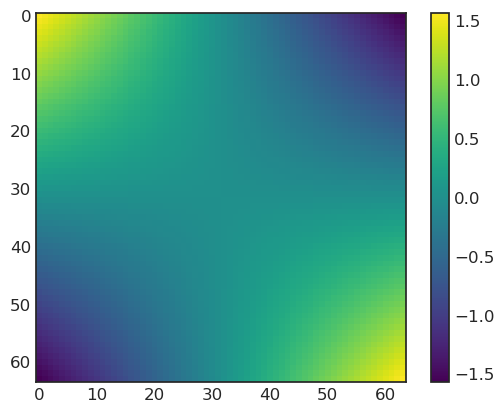

In [24]:
plt.imshow(Y_phi_train[0])
plt.colorbar()

### Norm conservation consistency check:

In [25]:
np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0])

1.0007815336823656

In [26]:
def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / h)

### Inversion symmetry check:

In [27]:
import fourier as f

In [28]:
# assert (normed_ff_np(Y_I_train[0, :, :, 0])[::-1, ::-1] == normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])).all()

In [29]:
normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(2 * Y_I_train[0, :, :, 0]).sum()

0.5

### np / tf consistency check:

In [30]:
i = 0

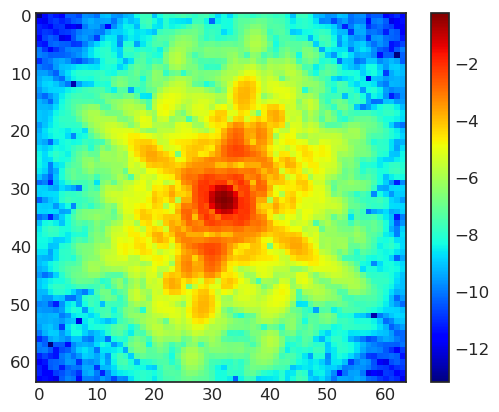

In [31]:
plt.imshow(np.log(normed_ff_np(Y_I_train[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

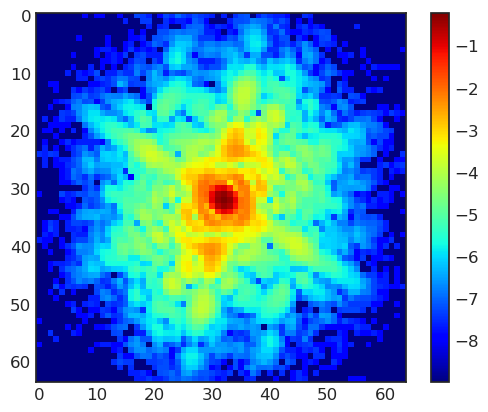

In [32]:
plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

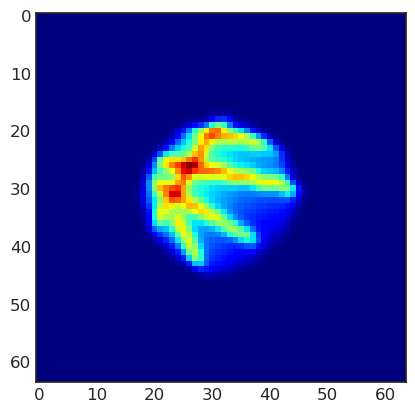

In [33]:
plt.imshow((np.squeeze(Y_I_train[i])), cmap = 'jet')

In [34]:
### Recover shift between scan points

# import numpy as np
# import scipy.signal

# def cross_image(im1, im2):
#     # get rid of the color channels by performing a grayscale transform
#     # the type cast into 'float' is to avoid overflows
#     im1_gray = im1#np.sum(im1.astype('float'), axis=2)
#     im2_gray = im2#np.sum(im2.astype('float'), axis=2)

#     # get rid of the averages, otherwise the results are not good
#     im1_gray -= np.mean(im1_gray)
#     im2_gray -= np.mean(im2_gray)

#     # calculate the correlation image; note the flipping of onw of the images
#     return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

### Full diffraction, no probe envelope:

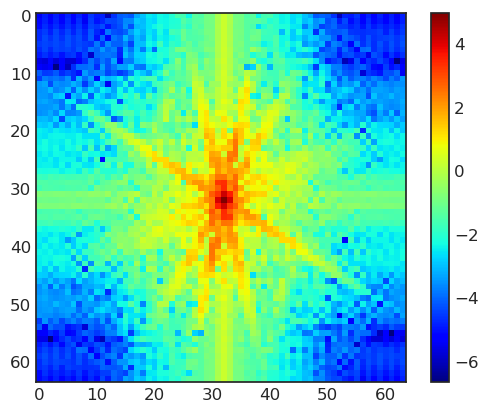

In [35]:
forward = (np.absolute(f.fftshift(f.fft2(f.gf(Y_I_train[i] / probe[..., None], 0.).squeeze()))))

plt.imshow(np.log(f.gf(forward, 0)), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [36]:
dummy_input = tf.zeros_like(X_train)

In [37]:
# %load keras_helper.py
#Keras modules
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, UpSampling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Input
import numpy as np



def Conv_Pool_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = MaxPool2D((p1, p2), padding=padding, data_format=data_format)(x0)
    return x0

def Conv_Up_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last',
        activation = 'relu'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation=activation, padding=padding, data_format=data_format)(x0)
    x0 = UpSampling2D((p1, p2), data_format=data_format)(x0)
    return x0

In [38]:
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.layers import Lambda

from importlib import reload
reload(hh)

import math

In [39]:
def get_mask(input, support_threshold):
    mask = tf.where(tf.math.abs(input) > support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    
#     mask = tf.where(tprobe[16:-16, 16:-16, :] > support_threshold, tf.ones_like(input),
#                     tf.zeros_like(input))
    return mask

def symmetrize(arr):
    return (arr + arr[::-1, ::-1]) / 2

def symmetrize_3d(arr):
    return (arr + arr[:, ::-1, ::-1]) / 2

def amplitude_difference(target, pred):
    """
    Calculate object MAE, taking into account that the prediction may be inverted
    """
    abs1 = tf.math.abs(target)
    abs2 = tf.math.abs(pred)
    abs3 = abs2[:, ::-1, ::-1, :]
    target_sym = tf.math.abs(symmetrize_3d(target))
    mae = tf.keras.losses.MeanAbsoluteError()
    a, b, c = mae(abs1, abs2), mae(abs1, abs3), mae(target_sym, pred)
    return tf.minimum(a, 
                      tf.minimum(b, c))

plt.rcParams["figure.figsize"] = (10, 10)

def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)


def summarize(i):
    norm =  (np.absolute(b)[i].max() / tmp2[i].max())
    # vmax = tmp2[i].max() * norm
    vmin = 0
    vmax = np.absolute(b)[i].max()

    aa, bb = 3, 3
    plt.subplot(aa, bb, 1)
    plt.title('Ground truth amp.')
    #cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((Y_I_test[i]), cmap = 'jet')

    plt.subplot(aa, bb, 2)
    plt.title('True amp. (symmetrized)')
    #cropshow((np.absolute(symmetrize(Y_I_test[i]))), cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((np.absolute(symmetrize(Y_I_test[i]))), cmap = 'jet')

    plt.subplot(aa, bb, 3)
    plt.title('Reconstructed amp.')
    #cropshow((np.absolute(b))[i] * probe[..., None], cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((np.absolute(b))[i] * probe[..., None], cmap = 'jet')

    plt.subplot(aa, bb, 4)
    plt.title('Reconstructed phase')
    cropshow((np.angle(b))[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 5)
    plt.title('True phase')
    cropshow((Y_phi_test)[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 6)
    plt.title('True diffraction')
    plt.imshow(np.log(X_test)[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 7)
    plt.title('Recon diffraction')
    plt.imshow(np.log(a)[i], cmap = 'jet')
    
def plt_metrics():
    hist=history
    epochs=np.asarray(history.epoch)+1

    %matplotlib inline
    import matplotlib
    plt.style.use('seaborn-white')
    matplotlib.rc('font',family='Times New Roman')
    matplotlib.rcParams['font.size'] = 12

    f, axarr = plt.subplots(2, sharex=True, figsize=(12, 8))

    axarr[0].set(ylabel='Loss')
    axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Diffraction MAE Training')
    axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Diffraction MAE Validation')
    axarr[0].grid()
    axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

    axarr[1].set(ylabel='Loss')
    axarr[1].plot(epochs,hist.history['padded_obj_loss'], 'C0o', label='Object MAE Training')
    axarr[1].plot(epochs,hist.history['val_padded_obj_loss'], 'C0-', label='Object MAE Validation')
    axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
    plt.xlabel('Epochs')
    plt.tight_layout()
    #plt.semilogy()
    axarr[1].grid()

In [40]:
#plt.imshow(tprobe[16:-16, 16:-16, :] > .05)

In [41]:
tprobe_small = tprobe[16:-16, 16:-16, :]

In [42]:
tf.keras.backend.clear_session()
np.random.seed(1)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

input_img = Input(shape=(h, w, 1), name = 'input') 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')

encoded=x

#Decoding arm for amplitude
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)
decoded1 = Lambda(lambda x: sigmoid(x), name='amp')(decoded1)


#Decoding arm for phase
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)
decoded2 = Lambda(lambda x: math.pi * tanh(x), name='phi')(decoded2)

# TODO global phase augmentation
# decoded2 = Lambda(lambda x: (np.random.uniform() - .5) * math.pi * 2 + x)(decoded2)

obj = Lambda(lambda x: hh.combine_complex(x[0], x[1]),
                     name='obj')([decoded1, decoded2])
obj = Lambda(lambda x: tf.cast(tprobe_small, tf.complex64) * x)(obj)

# # Add real space support
# support = Lambda(lambda x: get_mask(x, .02), name='support')(decoded1)
# obj = Lambda(lambda x: x[0] * tf.cast(x[1], tf.complex64),
#                             name='masked_obj')([obj, support])

# Diffracted amplitude
padded_obj, pred_diff = hh.pad_and_diffract(obj, h, w)


encoder = tf.keras.Model(inputs=[input_img],
                           outputs=[padded_obj])

# TODO add noise that respects nyquist criterion
def mul_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1, dtype=tf.float32)
        noise_img = image * noise
#         noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img

noisy_diff = mul_gaussian_noise(pred_diff)
feedback_obj = encoder(
    noisy_diff)

feedback_loss = tf.keras.losses.MeanAbsoluteError(name = 'foo')(padded_obj, feedback_obj)


#autoencoder = Model([input_img], [pred_diff, padded_obj])
autoencoder = Model([input_img], [pred_diff, padded_obj, feedback_loss])

# autoencoder.add_loss(feedback_loss)
# autoencoder.add_metric(feedback_loss, name='feedback_loss', aggregation='mean')

# Make an auxiliary model that exposes the real space object reconstruction
obj_layer_out = autoencoder.get_layer('obj').output
aux_model = tf.keras.Model(inputs=autoencoder.inputs,
                           outputs=[noisy_diff, feedback_obj])

In [43]:
def dummy_loss(target, pred):
    return pred

In [44]:
# # The second output exposes the real space object reconstruction but does not contribue to the training loss,
# # but it's used to calculate reconstruction errors for validation
# autoencoder.compile(optimizer='adam', loss=['mean_absolute_error', amplitude_difference, 'feedback_loss'],
#                     loss_weights = [0., 0., 1.]

# #                     loss_weights = [1., 0.]
# #                     {autoencoder.outputs[0].name.split('/')[0]: 'mean_absolute_error'}
#                    )

# The second output exposes the real space object reconstruction but does not contribue to the training loss,
# but it's used to calculate reconstruction errors for validation
autoencoder.compile(optimizer='adam',
     loss=['mean_absolute_error', amplitude_difference, dummy_loss],
     loss_weights = [1., 0., 0.0])

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                            

 tf.math.subtract (TFOpLambda)  (None, 64, 64, 1)    0           ['tf.convert_to_tensor[0][0]',   
                                                                  'tf.cast[0][0]']                
                                                                                                  
 tf.math.abs (TFOpLambda)       (None, 64, 64, 1)    0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (None, 64, 64)      0           ['tf.math.abs[0][0]']            
 a)                                                                                               
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 64, 64)      0           ['tf.math.reduce_mean[0][0]']    
 )                                                                                                
          

In [45]:
Y_I_train.max()

1.0

In [46]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

checkpoints= tf.keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.h5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)


# history=autoencoder.fit(X_train, X_train, shuffle=True, batch_size=batch_size, verbose=1, 
#                            epochs=nepochs, validation_split = 0.05, callbacks=[reduce_lr, earlystop])

history=autoencoder.fit([X_train], [X_train, Y_I_train, dummy_input], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=20, validation_split = 0.05, callbacks=[reduce_lr, earlystop, checkpoints])

a, b, loss = autoencoder.predict([X_test])

Epoch 1/20


2022-10-11 14:59:53.824226: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


446/446 [==============================] - ETA: 0s - loss: 0.0039 - lambda_3_loss: 0.0039 - padded_obj_loss: 0.0085 - tf.math.divide_no_nan_loss: 0.0074
Epoch 1: val_loss improved from inf to 0.00304, saving model to wts4.1/weights.01.h5


446/446 [==============================] - 11s 19ms/step - loss: 0.0039 - lambda_3_loss: 0.0039 - padded_obj_loss: 0.0085 - tf.math.divide_no_nan_loss: 0.0074 - val_loss: 0.0030 - val_lambda_3_loss: 0.0030 - val_padded_obj_loss: 0.0077 - val_tf.math.divide_no_nan_loss: 0.0113 - lr: 0.0010
Epoch 2/20
444/446 [============================>.] - ETA: 0s - loss: 0.0028 - lambda_3_loss: 0.0028 - padded_obj_loss: 0.0073 - tf.math.divide_no_nan_loss: 0.0099
Epoch 2: val_loss improved from 0.00304 to 0.00268, saving model to wts4.1/weights.02.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0028 - lambda_3_loss: 0.0028 - padded_obj_loss: 0.0073 - tf.math.divide_no_nan_loss: 0.0099 - val_loss: 0.0027 - val_lambda_3_loss: 0.0027 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0100 - lr: 0.0010
Epoch 3/20
445/446 [============================>.] - ETA: 0s - loss: 0.0025 - lambda_3_loss: 0.0025 - padded_obj_loss: 0.0071 - tf.math.divide_no_nan_loss: 0.0099
Epoch 3: val_loss improved from 0.00268 to 0.00232, saving model to wts4.1/weights.03.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0025 - lambda_3_loss: 0.0025 - padded_obj_loss: 0.0071 - tf.math.divide_no_nan_loss: 0.0099 - val_loss: 0.0023 - val_lambda_3_loss: 0.0023 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0102 - lr: 0.0010
Epoch 4/20
445/446 [============================>.] - ETA: 0s - loss: 0.0023 - lambda_3_loss: 0.0023 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0101
Epoch 4: val_loss improved from 0.00232 to 0.00220, saving model to wts4.1/weights.04.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0023 - lambda_3_loss: 0.0023 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0101 - val_loss: 0.0022 - val_lambda_3_loss: 0.0022 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0099 - lr: 0.0010
Epoch 5/20
445/446 [============================>.] - ETA: 0s - loss: 0.0022 - lambda_3_loss: 0.0022 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0104
Epoch 5: val_loss improved from 0.00220 to 0.00213, saving model to wts4.1/weights.05.h5


446/446 [==============================] - 8s 19ms/step - loss: 0.0022 - lambda_3_loss: 0.0022 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0104 - val_loss: 0.0021 - val_lambda_3_loss: 0.0021 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0111 - lr: 0.0010
Epoch 6/20
444/446 [============================>.] - ETA: 0s - loss: 0.0021 - lambda_3_loss: 0.0021 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0106
Epoch 6: val_loss improved from 0.00213 to 0.00203, saving model to wts4.1/weights.06.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0021 - lambda_3_loss: 0.0021 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0106 - val_loss: 0.0020 - val_lambda_3_loss: 0.0020 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0106 - lr: 0.0010
Epoch 7/20
443/446 [============================>.] - ETA: 0s - loss: 0.0020 - lambda_3_loss: 0.0020 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0107
Epoch 7: val_loss improved from 0.00203 to 0.00198, saving model to wts4.1/weights.07.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0020 - lambda_3_loss: 0.0020 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0107 - val_loss: 0.0020 - val_lambda_3_loss: 0.0020 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0105 - lr: 0.0010
Epoch 8/20
446/446 [==============================] - ETA: 0s - loss: 0.0020 - lambda_3_loss: 0.0020 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0107
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 0.00198
446/446 [==============================] - 8s 18ms/step - loss: 0.0020 - lambda_3_loss: 0.0020 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0107 - val_loss: 0.0021 - val_lambda_3_loss: 0.0021 - val_padded_obj_loss: 0.0072 - val_tf.math.divide_no_nan_loss: 0.0109 - lr: 0.0010
Epoch 9/20
446/446 [==============================] - ETA: 0s - loss: 0.0018 - lambda_3_loss: 0.0018 - padded_obj_loss: 0.0070 - tf.ma

446/446 [==============================] - 8s 18ms/step - loss: 0.0018 - lambda_3_loss: 0.0018 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0108 - val_loss: 0.0018 - val_lambda_3_loss: 0.0018 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0107 - lr: 5.0000e-04
Epoch 10/20
444/446 [============================>.] - ETA: 0s - loss: 0.0018 - lambda_3_loss: 0.0018 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0110
Epoch 10: val_loss did not improve from 0.00185
446/446 [==============================] - 8s 18ms/step - loss: 0.0018 - lambda_3_loss: 0.0018 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0110 - val_loss: 0.0018 - val_lambda_3_loss: 0.0018 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0107 - lr: 5.0000e-04
Epoch 11/20
446/446 [==============================] - ETA: 0s - loss: 0.0018 - lambda_3_loss: 0.0018 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0109
Epoch 11: ReduceLROnPlateau reducing

446/446 [==============================] - 8s 18ms/step - loss: 0.0018 - lambda_3_loss: 0.0018 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0109 - val_loss: 0.0018 - val_lambda_3_loss: 0.0018 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0106 - lr: 5.0000e-04
Epoch 12/20
444/446 [============================>.] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0111
Epoch 12: val_loss improved from 0.00181 to 0.00178, saving model to wts4.1/weights.12.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0111 - val_loss: 0.0018 - val_lambda_3_loss: 0.0018 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0114 - lr: 2.5000e-04
Epoch 13/20
445/446 [============================>.] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0111
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: val_loss improved from 0.00178 to 0.00177, saving model to wts4.1/weights.13.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0111 - val_loss: 0.0018 - val_lambda_3_loss: 0.0018 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0111 - lr: 2.5000e-04
Epoch 14/20
444/446 [============================>.] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0112
Epoch 14: val_loss improved from 0.00177 to 0.00174, saving model to wts4.1/weights.14.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0112 - val_loss: 0.0017 - val_lambda_3_loss: 0.0017 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0111 - lr: 1.2500e-04
Epoch 15/20
443/446 [============================>.] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0112
Epoch 15: val_loss improved from 0.00174 to 0.00174, saving model to wts4.1/weights.15.h5


446/446 [==============================] - 8s 18ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0112 - val_loss: 0.0017 - val_lambda_3_loss: 0.0017 - val_padded_obj_loss: 0.0070 - val_tf.math.divide_no_nan_loss: 0.0112 - lr: 1.2500e-04
Epoch 16/20
444/446 [============================>.] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0113
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 16: val_loss improved from 0.00174 to 0.00173, saving model to wts4.1/weights.16.h5


446/446 [==============================] - 8s 19ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0113 - val_loss: 0.0017 - val_lambda_3_loss: 0.0017 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0115 - lr: 1.2500e-04
Epoch 17/20
446/446 [==============================] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0114
Epoch 17: val_loss improved from 0.00173 to 0.00172, saving model to wts4.1/weights.17.h5


446/446 [==============================] - 8s 19ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0114 - val_loss: 0.0017 - val_lambda_3_loss: 0.0017 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0114 - lr: 1.0000e-04
Epoch 18/20
446/446 [==============================] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0114
Epoch 18: val_loss did not improve from 0.00172
446/446 [==============================] - 8s 18ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0114 - val_loss: 0.0017 - val_lambda_3_loss: 0.0017 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0115 - lr: 1.0000e-04
Epoch 19/20
444/446 [============================>.] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0114
Epoch 19: val_loss improved from 0.0

446/446 [==============================] - 8s 18ms/step - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0114 - val_loss: 0.0017 - val_lambda_3_loss: 0.0017 - val_padded_obj_loss: 0.0069 - val_tf.math.divide_no_nan_loss: 0.0114 - lr: 1.0000e-04
Epoch 20/20
445/446 [============================>.] - ETA: 0s - loss: 0.0017 - lambda_3_loss: 0.0017 - padded_obj_loss: 0.0070 - tf.math.divide_no_nan_loss: 0.0114
Epoch 20: val_loss improved from 0.00171 to 0.00171, saving model to wts4.1/weights.20.h5


157/157 [==============================] - 1s 7ms/step


In [47]:
i = 501

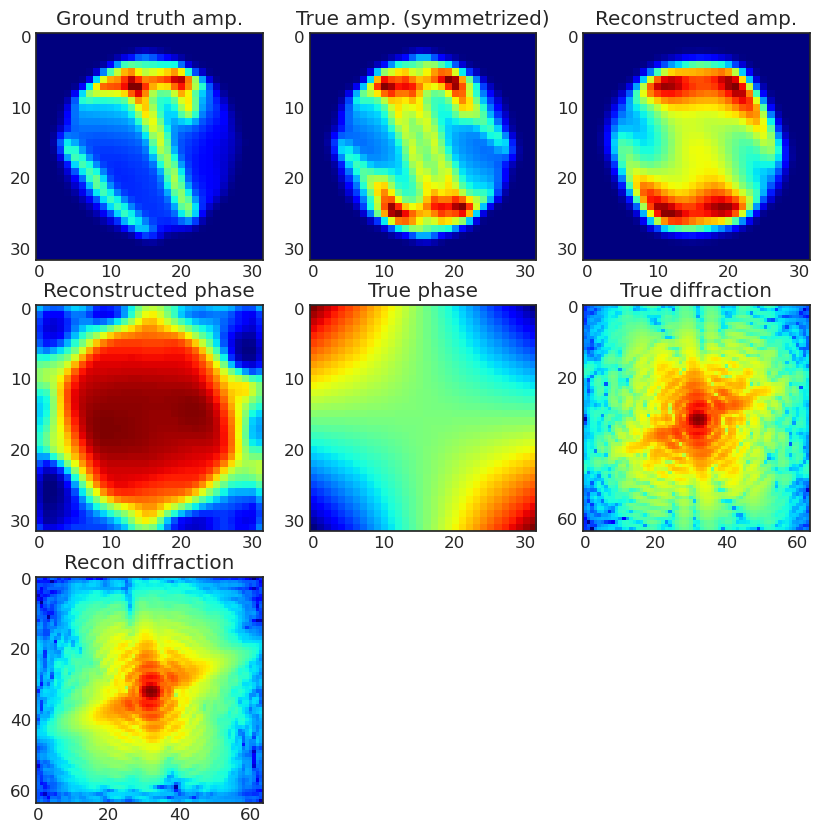

In [109]:
summarize(i)

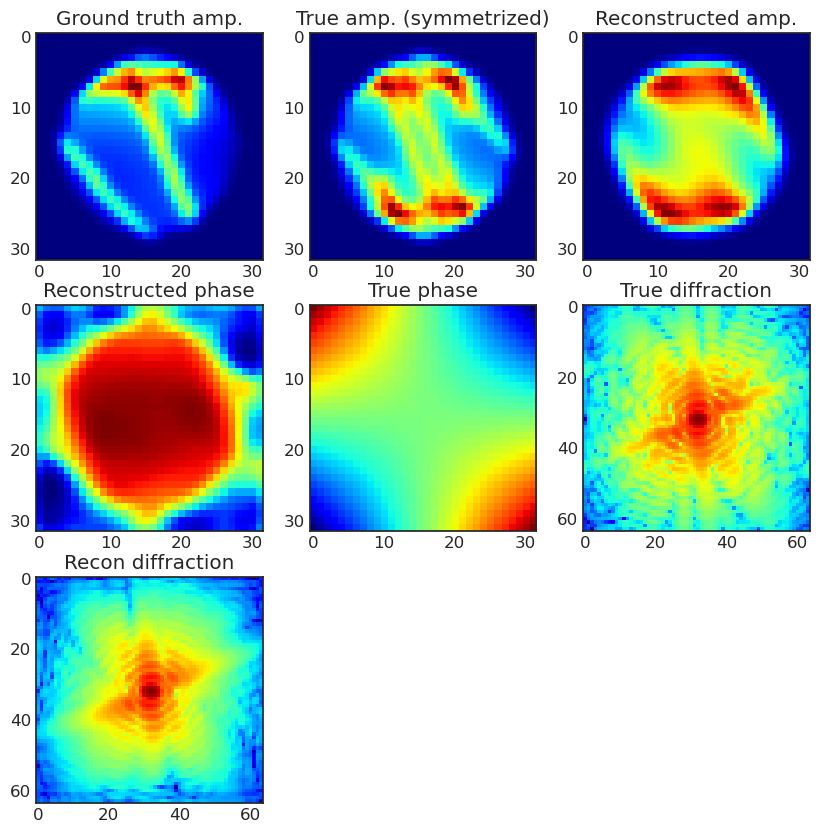

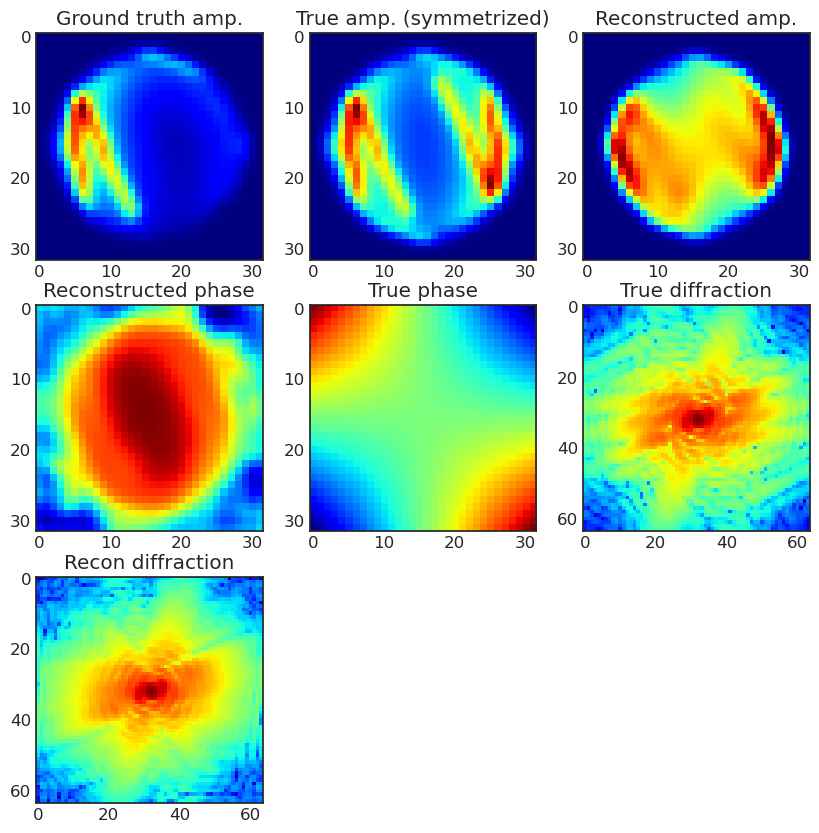

In [49]:
summarize(505)

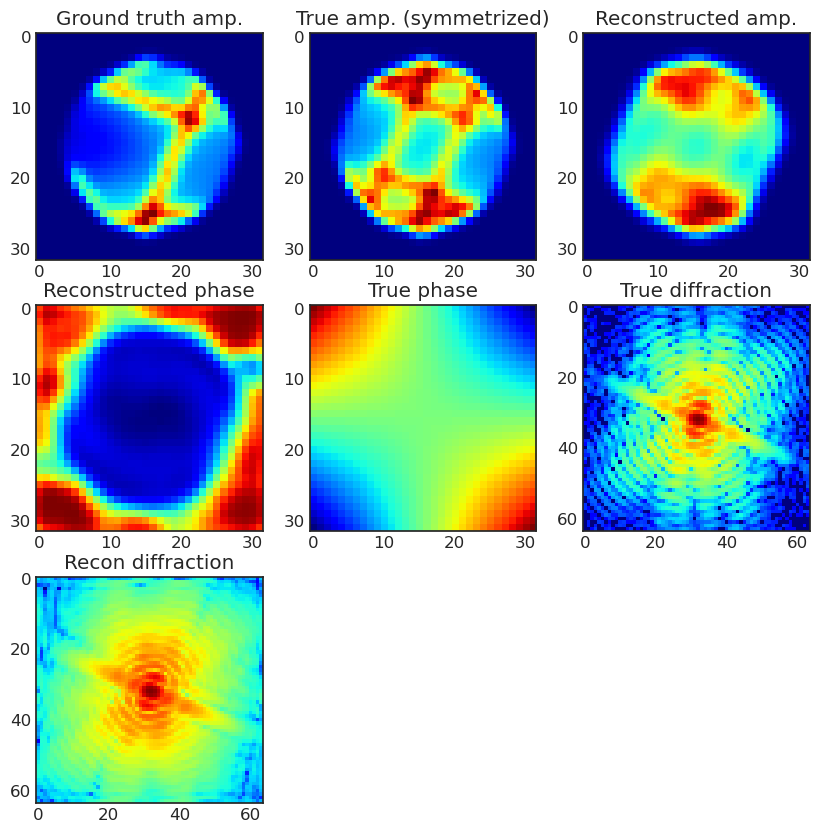

In [92]:
summarize(505)

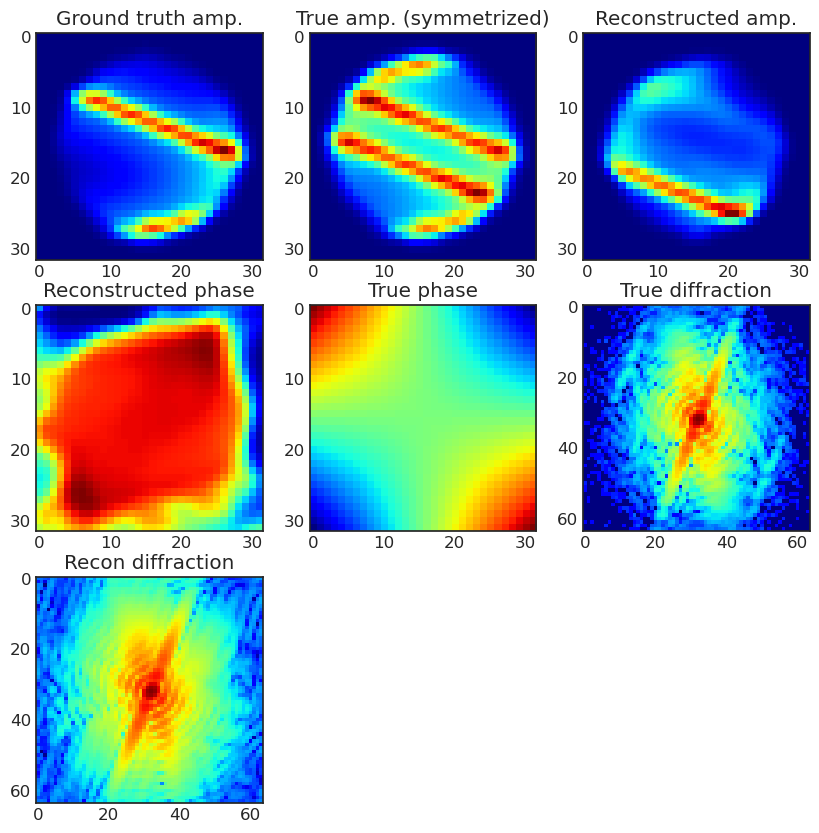

In [48]:
summarize(505)

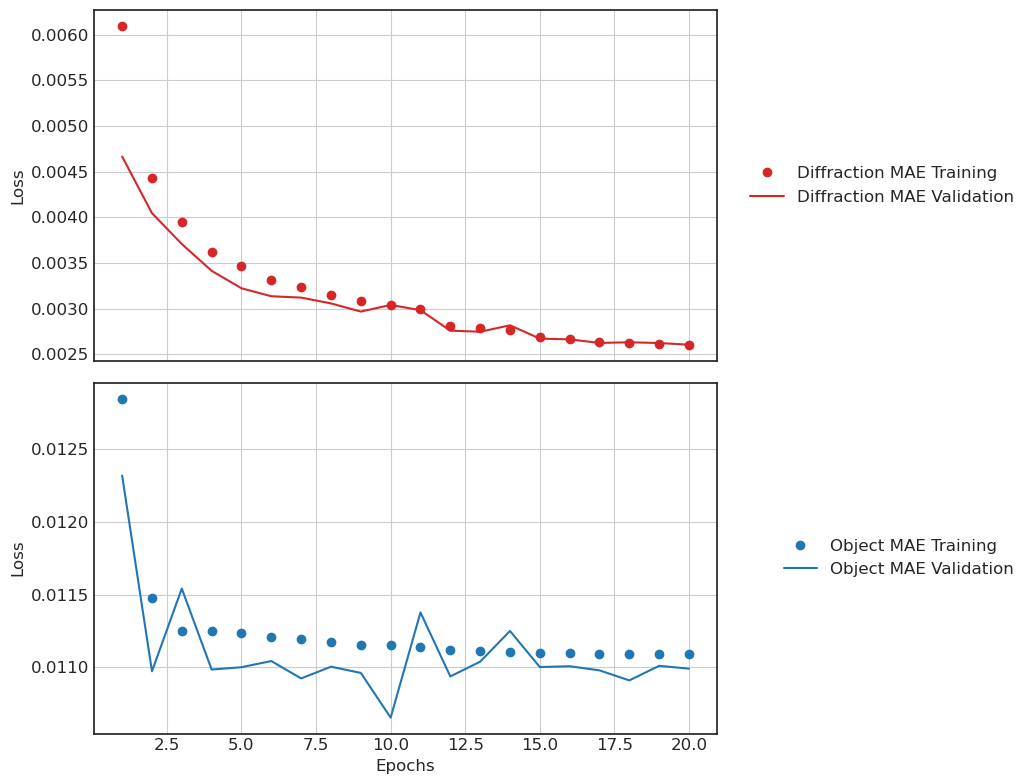

In [52]:
plt_metrics()

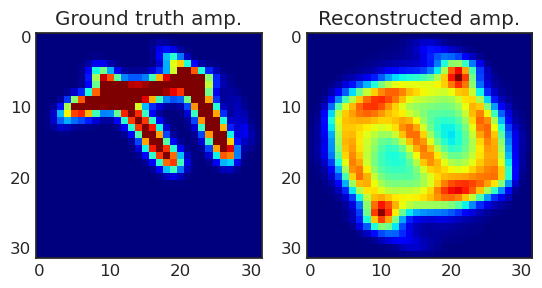

In [88]:
def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)
    
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = np.absolute(b)[i].max()

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

In [54]:
noisy, no = aux_model([X_test[:100]])

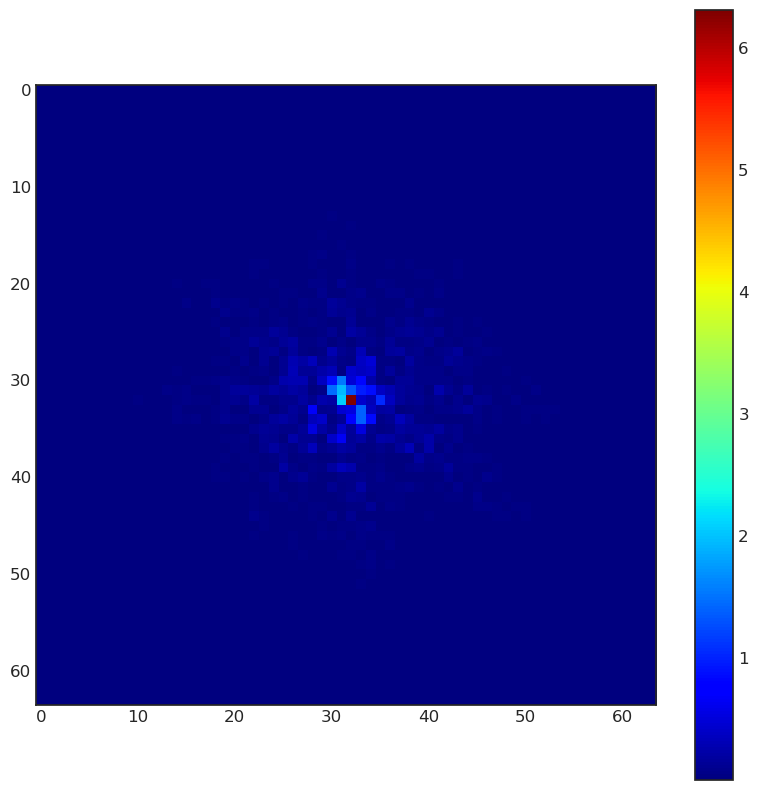

In [55]:
plt.imshow(np.absolute(noisy)[0], cmap = 'jet')
plt.colorbar()

In [56]:
c, d, _ = autoencoder.predict([noisy])

4/4 [==============================] - 0s 26ms/step


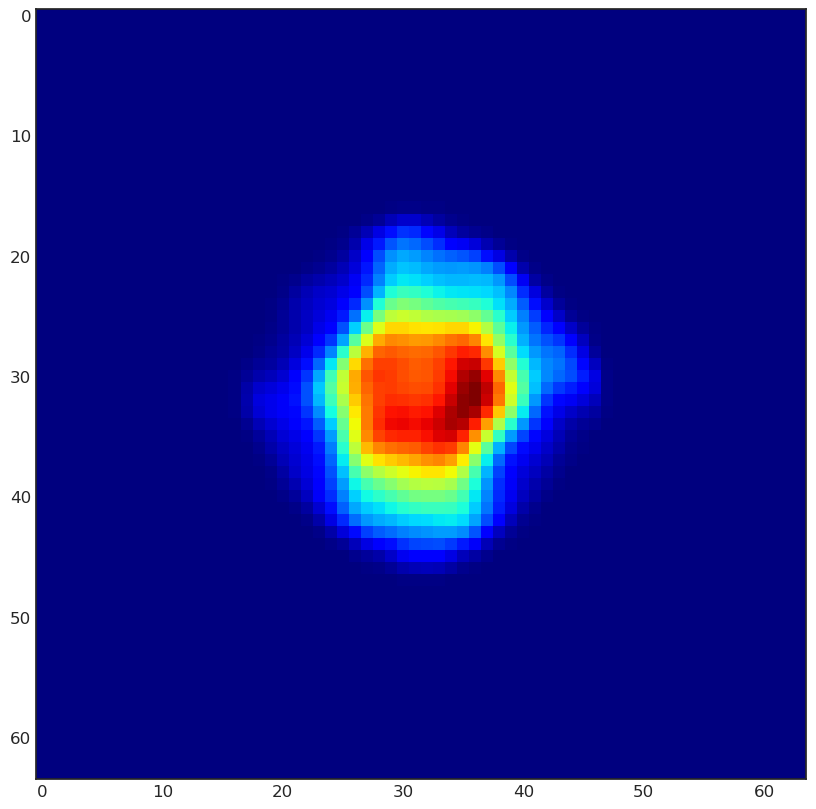

In [57]:
plt.imshow(np.absolute(d)[0], cmap = 'jet')

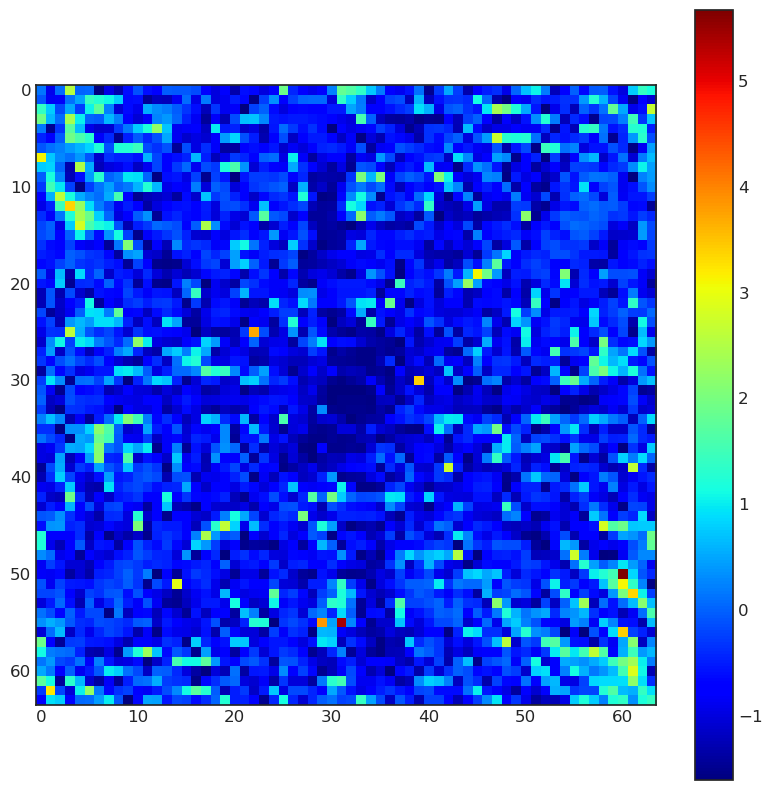

In [58]:
plt.imshow(np.log(.2 + np.abs((a[i] - X_test[i]) / (X_test[i] + 1e-9))), cmap ='jet')
plt.colorbar()

In [61]:
tmp = np.absolute(b) - np.absolute(d)

ValueError: operands could not be broadcast together with shapes (5000,64,64,1) (100,64,64,1) 

In [71]:
tmp2 = Y_I_test

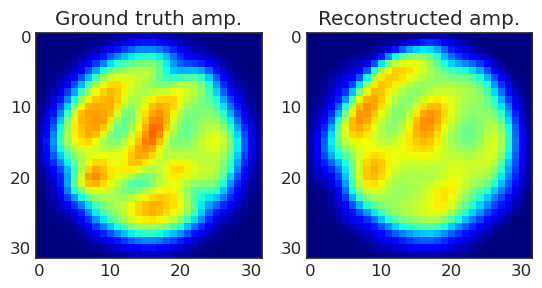

In [46]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

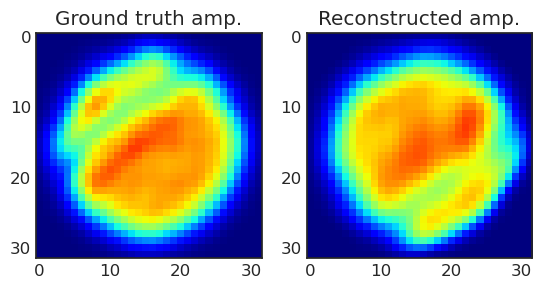

In [36]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

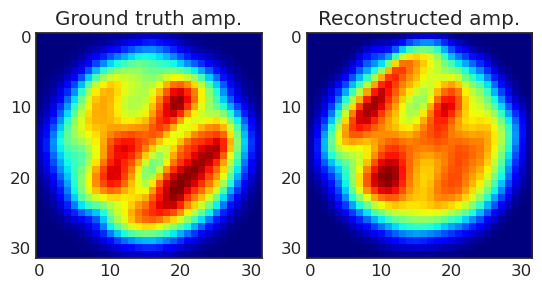

In [37]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

In [38]:
amplitude_difference(Y_I_test[i:i + 1], (np.absolute(b)[i:i + 1]))

tf.Tensor(0.014161492, shape=(), dtype=float32) tf.Tensor(0.012130551, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.012130551>

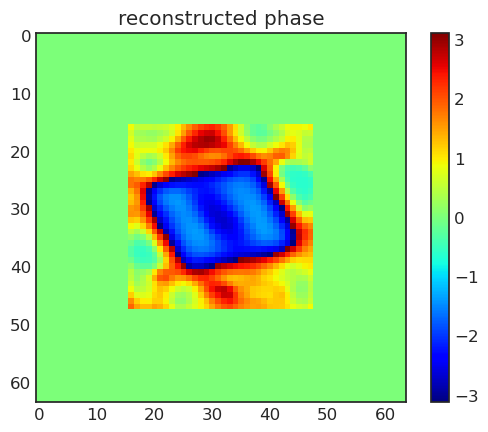

In [89]:
plt.title('reconstructed phase')
plt.imshow((np.angle(b))[i], cmap = 'jet')
plt.colorbar()

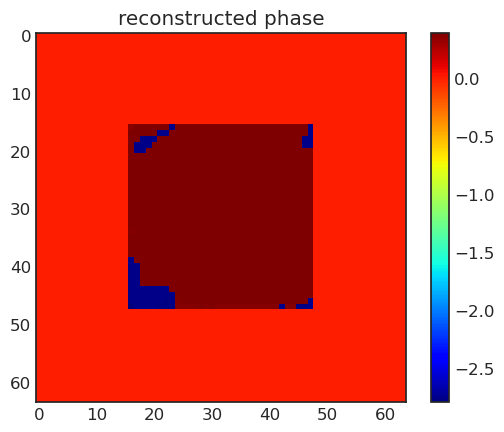

In [44]:
plt.title('reconstructed phase')
plt.imshow((np.angle(b))[i], cmap = 'jet')
plt.colorbar()

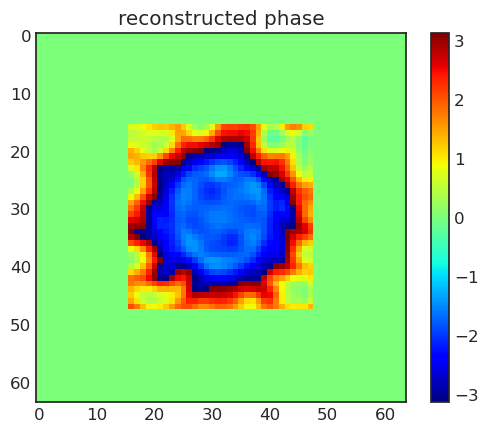

In [89]:
plt.title('reconstructed phase')
plt.imshow((np.angle(b))[i + 100], cmap = 'jet')
plt.colorbar()

In [62]:
# !ln ../xrd_clustering/notebooks/visualization.py

In [51]:
import visualization as vis
# reload(vis)

In [52]:
vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + 10])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + 10])

diffraction reconstruction


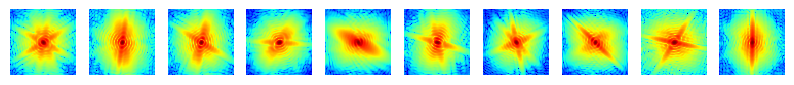

object reconstruction (amp)


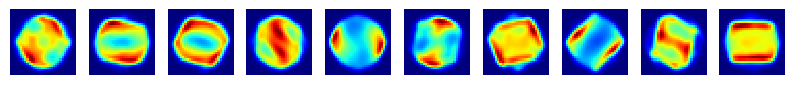

object reconstruction (phase)


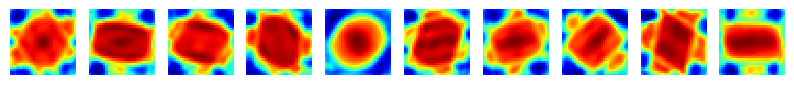

object ground truth (symmetric)


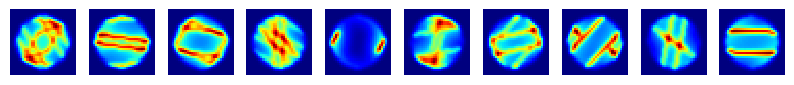

object ground truth


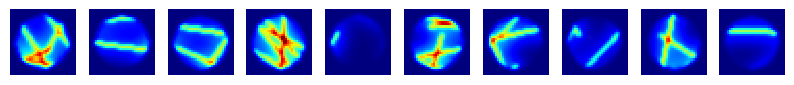

In [80]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

diffraction reconstruction


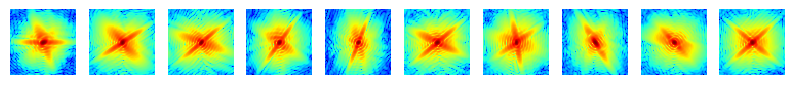

object reconstruction (amp)


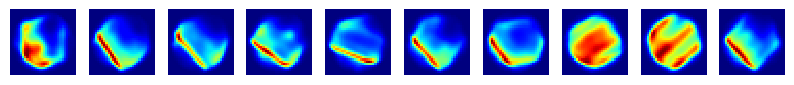

object reconstruction (phase)


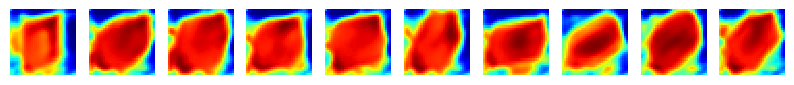

object ground truth (symmetric)


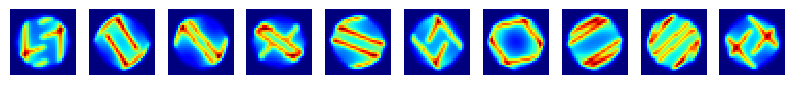

object ground truth


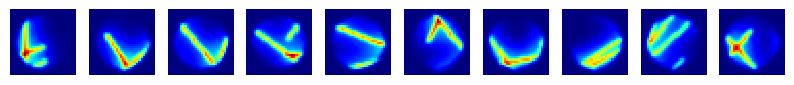

In [53]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

ground truth


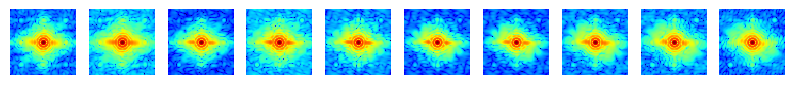

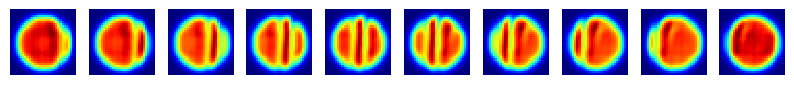

reconstruction


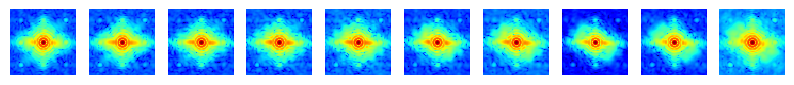

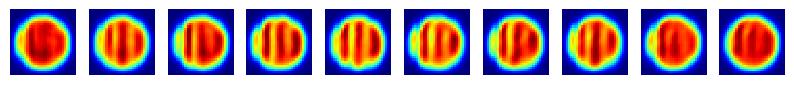

In [180]:
i = 800
print('ground truth')
vis.display_imgs(np.log(X_test[i:i + 10]))
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10])


print('reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])

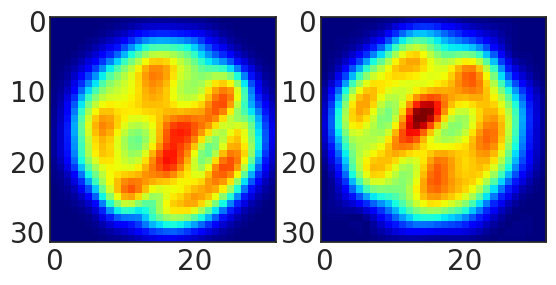

In [110]:
off = 1
i = 607

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.imshow((Y_I_test[i, 16:-16, 16:-16]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.imshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

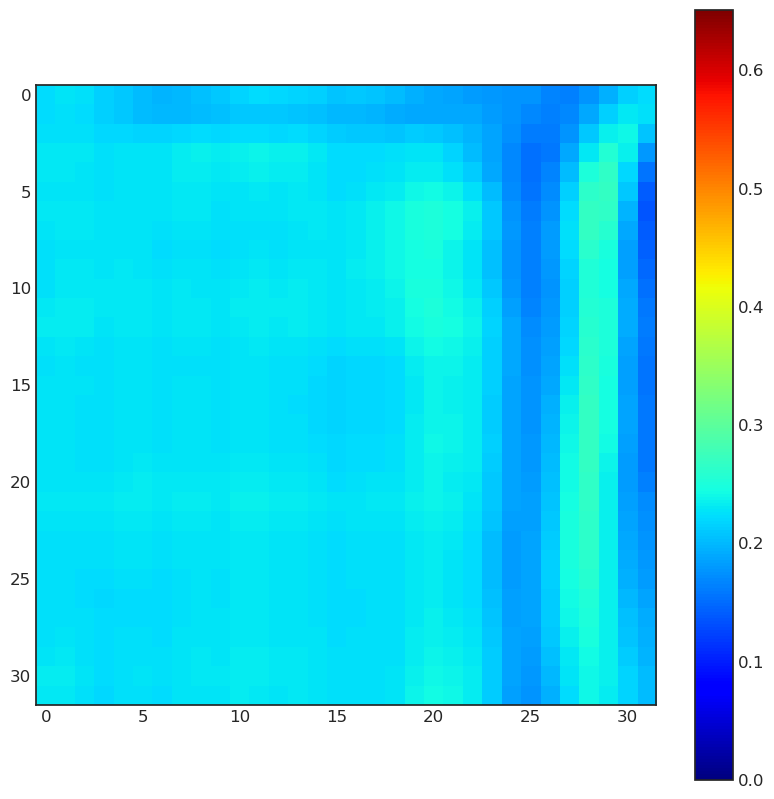

In [71]:
cropshow((tmp2[i] * norm), cmap = 'jet', vmin = 0, vmax = vmax)# tmp2.min(), vmax = tmp2.max())
plt.colorbar()

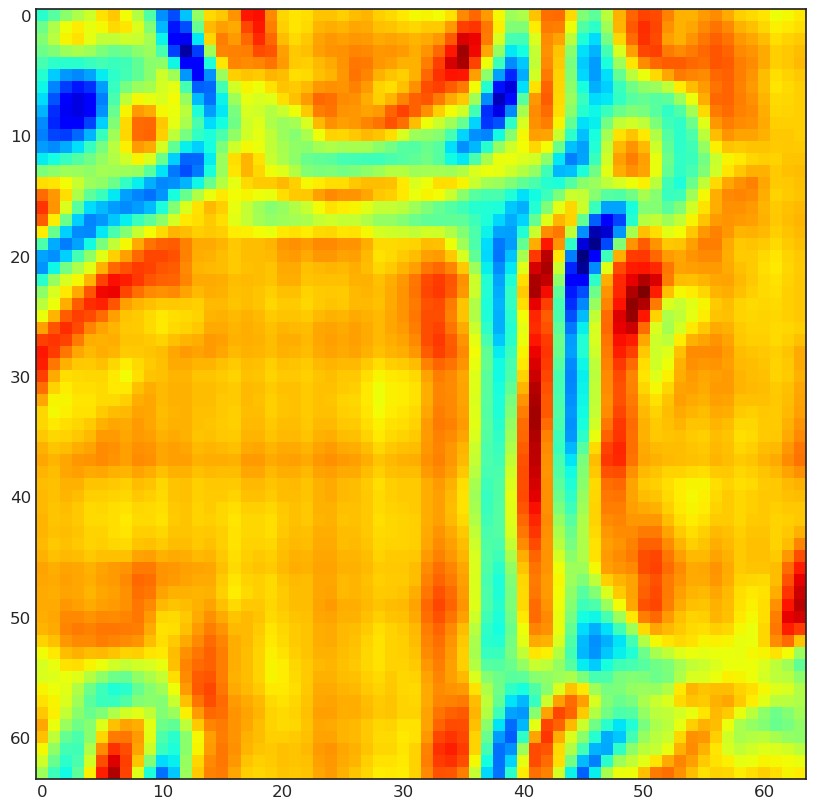

In [72]:
plt.imshow(np.log(off + tmp2[i + 1]), cmap = 'jet')

## Training metrics

In [75]:
hist.history.keys()

dict_keys(['loss', 'lambda_3_loss', 'padded_obj_loss', 'tf.math.divide_no_nan_loss', 'val_loss', 'val_lambda_3_loss', 'val_padded_obj_loss', 'val_tf.math.divide_no_nan_loss', 'lr'])

In [76]:
np.save(path+'str_history', history.history)

In [59]:
# model.load_weights(checkpoint_filepath)

'wts4.1/weights.03.h5'

In [77]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))

In [78]:
!du -sh wts4.h5

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
13M	wts4.h5
